In [1]:
#pip install rasterio

In [2]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.features import rasterize

# Define pixel values for each feature
pixel_values = {
    'road_bound': {
        'cycle_lane': [0, 40, 200],
        'motorized': [0, 45, 0],
        'pedestrian_walkway': [0, 85, 0],
        'traffic_island': [0, 45, 70]
    },
    'buildings': [255, 0, 0],
    'road_markings': {
        'broken_line': [0, 20, 10],
        'cycle_lane': [0, 40, 0],
        'dashed_line': [0, 45, 70],
        'pedestrian_crossing': [0, 100, 0],
        'solid_line': [0, 45, 0],
        'stop_line': [0, 85, 0]
    }
}

# Open the raster file (assuming the raster file is named 'raster.tif')
raster_file = 'dataset_ex_2/dop20rgb_386_5826_2022_grid_111.tif'
with rasterio.open(raster_file) as src:
    raster_meta = src.meta.copy()

# Create an empty RGB image
rgb_image = np.zeros((raster_meta['height'], raster_meta['width'], 3), dtype=np.uint8)

def add_shapes_to_image(geodataframe, pixel_value, transform):
    # Rasterize shapes
    mask = rasterize(
        [(geom, 1) for geom in geodataframe.geometry],
        out_shape=(raster_meta['height'], raster_meta['width']),
        transform=transform,
        fill=0,
        default_value=1
    )

    # Add pixel value to the image where mask is 1
    for i in range(3):
        rgb_image[:, :, i] = np.where(mask == 1, pixel_value[i], rgb_image[:, :, i])

# Assuming shapefiles are named 'road_bound.shp', 'buildings.shp', and 'road_markings.shp'
shapefiles = {
    'buildings': "dataset_ex_2/grid-111/dop20rgb_386_5826_2022_buildings_grid-111.shp",
    'road_markings': "dataset_ex_2/grid-111/dop20rgb_386_5826_2022_markings_grid-111.shp",
    'road_bound': "dataset_ex_2/grid-111/dop20rgb_386_5826_2022_bounds_grid-111.shp"
}

# Add buildings
buildings_gdf = gpd.read_file(shapefiles['buildings'])
add_shapes_to_image(buildings_gdf, pixel_values['buildings'], src.transform)

# Add road markings
road_markings_gdf = gpd.read_file(shapefiles['road_markings'])
for marking_type, pixel_value in pixel_values['road_markings'].items():
    marking_gdf = road_markings_gdf[road_markings_gdf['attributes'] == marking_type]  # Adjust 'attributes' to the actual attribute name
    add_shapes_to_image(marking_gdf, pixel_value, src.transform)

# Add road bounds
road_bound_gdf = gpd.read_file(shapefiles['road_bound'])
for road_type, pixel_value in pixel_values['road_bound'].items():
    bound_gdf = road_bound_gdf[road_bound_gdf['attributes'] == road_type]  # Adjust 'attributes' to the actual attribute name
    add_shapes_to_image(bound_gdf, pixel_value, src.transform)

# Save the RGB image as a new raster file
output_file = 'output_rgb_mask-newH.tif'
with rasterio.open(output_file, 'w', **raster_meta) as dst:
    for i in range(3):
        dst.write(rgb_image[:, :, i], i + 1)


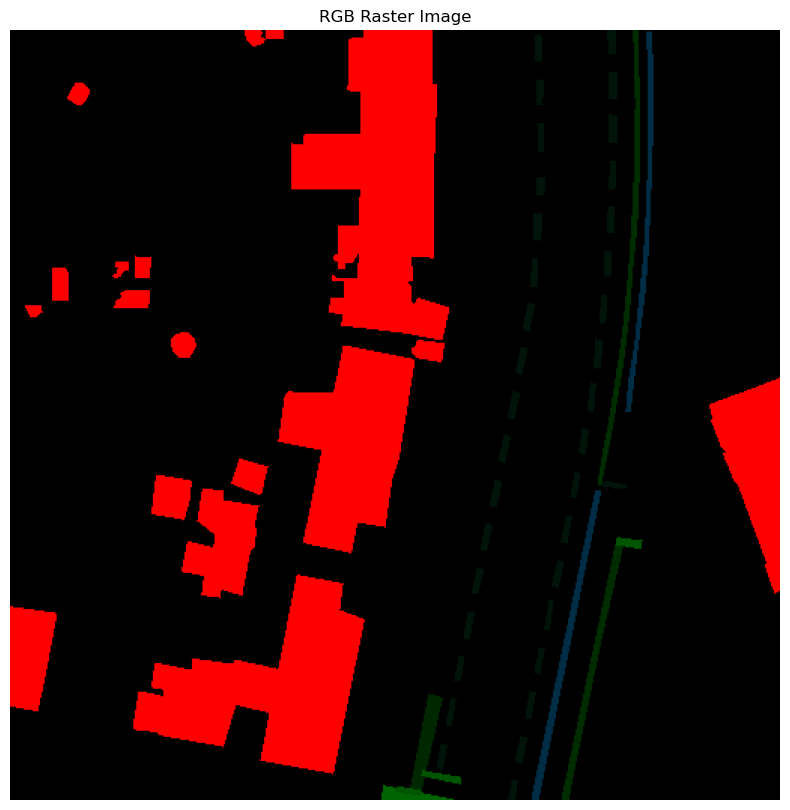

In [3]:
import matplotlib.pyplot as plt

# Path to the output raster file
output_file = 'output_rgb_mask-newH.tif'

# Open the raster file
with rasterio.open(output_file) as src:
    # Read the RGB bands
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)

    # Stack the RGB bands into a single image array
    rgb_image = np.stack((red, green, blue), axis=-1)

# Plot the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title("RGB Raster Image")
plt.axis('off')
plt.show()
